Support Vector Machines are a standard ML model for supervised classification. The basic idea behind a (linear) SVM is to find a separating hyperplane for two categories of points. Additionally, to make the model as generic as possible, SVM tries to make the margin separating the two sets of points as wide as possible. When a linear separator is not enough, SVM can be made non-linear with the kernel trick. 

Step 1: load and visualize the iris data

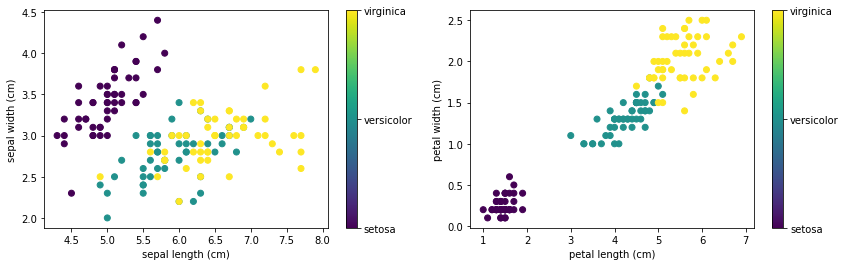

In [1]:
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris

def plot(x_index, y_index):
    formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
    plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
    plt.colorbar(ticks=[0, 1, 2], format=formatter)
    plt.xlabel(iris.feature_names[x_index])
    plt.ylabel(iris.feature_names[y_index])

iris = load_iris()
plt.figure(figsize=(14, 4))
plt.subplot(121)
plot(0, 1)
plt.subplot(122)
plot(2, 3)
plt.show()

In [7]:
print(y)
print(iris)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]
{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7

Step 2: split the dataset for cross validation; train the SVM

The separating hyperplane is defined by the wx - b = 0 equation, where w is the normal vector and b is a scalar offset. w’s dimendionality is however many features we have. Additionally, we will try to place the plane in such a way that it falls halfway between the two classes, so that, if possible, there are no points behind the wx - b = ±1 lines (see first image). For each training point x, we want wx - b > 1 if x is in the +1 class, wx - b < -1 if x is in the -1 class (we re-label classes to ±1). Calling the labels y, we can multiply both equations to get the same thing: y ( wx - b) > 1, or 1 - y ( wx - b ) < 0.

So our constraint is for these expressions to be less than zero for each training point. If it’s positive, that’s “bad”. If it’s negative, we don’t really care how negative it is. This leads to the loss function: ∑ max[0, 1 - y ( wx - b ) ]. To make it optimizer friendly, we square it: ∑ max[0, 1 - y ( wx - b ) ]².

There is a caveat though. What if the training points overlap? Or, there is just a few points which would cause the separating hyperplane’s margin to be very narrow? As the first picture shows, the width of the margin is 2/|w|, we also want to maximize this, or, minimize |w|/2, so the model generalizes better. So the full loss function is: |w|/2 + C ∑ max[0, 1 - y ( wx - b ) ]². C is an important hyperparameter, it sets the importance of separating all the points and pushing them outside the margin versus getting a wide margin.

In [3]:
from sklearn.model_selection import train_test_split
from random import random, shuffle
import numpy as np
import torch

X = [[x[2], x[3]] for x in iris.data]
y = iris.target.copy()
for i in range(len(y)):
    if y[i] == 0: y[i] = 1
    else: y[i] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dim = len(X[0])
w = torch.autograd.Variable(torch.rand(dim), requires_grad=True)
b = torch.autograd.Variable(torch.rand(1),   requires_grad=True)

step_size = 1e-3
num_epochs = 5000
minibatch_size = 20

for epoch in range(num_epochs):
    inds = [i for i in range(len(X_train))]
    shuffle(inds)
    for i in range(len(inds)):
        L = max(0, 1 - y_train[inds[i]] * (torch.dot(w, torch.Tensor(X_train[inds[i]])) - b))**2
        if L != 0: # if the loss is zero, Pytorch leaves the variables as a float 0.0, so we can't call backward() on it
            L.backward()
            w.data -= step_size * w.grad.data # step
            b.data -= step_size * b.grad.data # step
            w.grad.data.zero_()
            b.grad.data.zero_()

print('plane equation:  w=', w.detach().numpy(), 'b =', b.detach().numpy()[0])

plane equation:  w= [-0.84086263 -1.4831216 ] b = -3.1859126


Step 3: evaluate the accuracy

In [4]:
def accuracy(X, y):
    correct = 0
    for i in range(len(y)):
        y_predicted = int(np.sign((torch.dot(w, torch.Tensor(X[i])) - b).detach().numpy()[0]))
        if y_predicted == y[i]: correct += 1
    return float(correct)/len(y)

print('train accuracy', accuracy(X_train, y_train))
print('test accuracy', accuracy(X_test, y_test))

train accuracy 1.0
test accuracy 1.0


Step 4: show the 

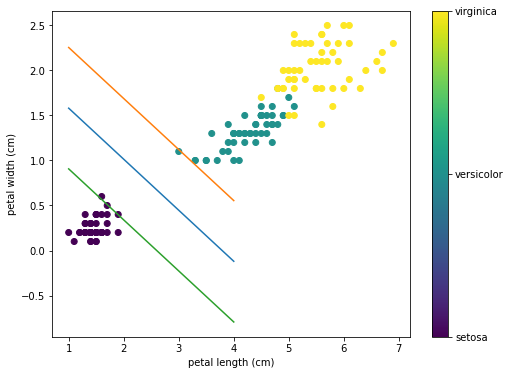

In [5]:
def line_func(x, offset):
    return   -1 * (offset - b.detach().numpy()[0] + w.detach().numpy()[0] * x ) / w.detach().numpy()[1]

x = np.array(range(1, 5))
ym = line_func(x,  0)
yp = line_func(x,  1)
yn = line_func(x, -1)

x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)